# Processamento de Linguagem Natural (NLP) - State Space Models

Professor: Arlindo Rodrigues Galvão Filho \\
Autor: Arthur Ricardo de Sousa Vitória

Data: 16/09/2024

## Cronograma

* Mamba

[1] Mamba: Linear-Time Sequence Modeling with Selective State Spaces (Albert Gu and Tri Dao) - https://arxiv.org/abs/2312.00752


---


* Glossário:
    *    b: batch size                       (`B`, Definido em: Algoritmo 2 [1])
    *    l: tamanho da sentença              (`L`, Definido em: Algoritmo 2 [1])
    *    d or d_model: hidden dim
    *    n or d_state: latent state dim      (`N`, Definido em: Algoritmo 2 [1])
    *    expand: Fator de expansão           (`E`, Definido em: Sessão 3.4 [1])
    *    d_in or d_inner: d * expand         (`D`, Definido em: Algoritmo 2 [1])
    *    A, B, C, D: state space (B, C são input-dependent (aka selective); A, D não)
    *    
    *    Δ ou delta: input-dependent step
    *    dt_rank: rank de Δ                  (Sessão 3.6 "Parameterization of ∆" [1])

In [1]:
import math
import json
import torch
import torch.nn as nn
import torch.nn.functional as F
from dataclasses import dataclass
from einops import rearrange, repeat, einsum
from transformers import AutoTokenizer

from typing_extensions import Union, List

### Primeiro vamos definir os parâmetros necessários para instanciar o modelo [1] e cada componente de sua arquitetura.

> Complete o código de acordo com o que é pedido

> Para isso, alguns parâmetros são necessários, definidos na classe '''MambaArgs'''.
> 1. Defina uma parametrização inicial para iniciar os testes.

In [2]:
CACHE_DIR=''

@dataclass
class MambaArgs:
    d_model: int
    n_layer: int
    vocab_size: int
    d_state: int = 16
    expand: int = 2
    dt_rank: Union[int, str] = 'auto'
    d_conv: int = 4
    pad_vocab_size_multiple: int = 8
    conv_bias: bool = True
    bias: bool = False

    def __post_init__(self):
        self.d_inner = int(self.expand * self.d_model)

        if self.dt_rank == 'auto':
            self.dt_rank = math.ceil(self.d_model / 16)

        if self.vocab_size % self.pad_vocab_size_multiple != 0:
            self.vocab_size += self.pad_vocab_size_multiple - self.vocab_size % self.pad_vocab_size_multiple

## 1.
args = MambaArgs(
    d_model=512,
    n_layer=4,
    vocab_size=10
)


args

MambaArgs(d_model=512, n_layer=4, vocab_size=16, d_state=16, expand=2, dt_rank=32, d_conv=4, pad_vocab_size_multiple=8, conv_bias=True, bias=False)

Para preencher os parâmetros, percebi que só existiam 3 parâmetros obrigatórios, sendo eles:
- d_model: É como se fosse o tamanho do hidden state de uma rnn, definindo o tamanho (dimensão) do embedding do vetor e dos hiddens.
- n_layer: Número de camadas, meio que encapsulamos toda ideia do mamba em uma camada, e repetimos isso n_layer vezes.
- vocab_size: Tamanho do vocabulário

#### Definir o bloco Mamba, como descrito na Figura 3, Sessão 3.4 do paper [1].

> Complete o código de acordo com o que é pedido

> Para testar o bloco 'MambaBlock' siga os seguintes passos:
> 1. Instancie o tokenizador do huggingface: 'EleutherAI/gpt-neox-20b'
> 2. Crie uma Camada responsável pela representação do seu vocabulário;
> 3. tokenize a entrada e gere a representação da sentença;
> 4. Uma vez gerada a entrada, passe a mesma para um MambaBlock;
>         - A entrada deve ter a mesma dimensão da saída;
>         - Printe algumas saídas para entender o funcionamento do bloco;
> 5. Printe a entrada e saída do bloco;



---



> ✳✳✳✳ **Desafio: Implementar o scan de forma paralela e chegar próximo aos resultados do sequencial** ✳✳✳✳




Na camada de projeção interna, entramos com o tamanho do embedding e do hidden, saimos com 2 x d_inner. É possível reparar que d_inner é 2 x d_model, logo, saimos com 4 vezes o tamanho do embedding na camada de projeção interna, como proposto originalmente.

Como mais para frente o resultado da linear será dividido entre X e res, ficamos novamente somente com d_inner de tamanho, sendo esse o tamanho de entrada da conv

A camada de projeção final pega esse resultado de tamanho d_inner e volta para o tamanho do embedding e hidden, para que o processo possa ser refeito no próximo mamba block

In [3]:
class MambaBlock(nn.Module):
    def __init__(self, args: MambaArgs):

        super().__init__()
        self.args = args

        """
            1. Criar camada de projeção interna que tenha como saída (2*d_inner), de acordo com paper
        """
        ## 1.
        self.in_proj = nn.Linear(in_features=args.d_model,
                                 out_features = 2 * args.d_inner,
                                 bias=args.bias)

        """
            1. Criar camada de convolução 1d, a entrada é dada após a projeção interna
                - os outros parâmetros relacionados a convolução estão definidos nos args.
        """
        ## 1.
        self.conv1d = nn.Conv1d(
          in_channels=args.d_inner,
          out_channels=args.d_inner,
          kernel_size=args.d_conv,
          padding=args.d_conv - 1,
          bias=args.conv_bias,
          groups=args.d_inner
      )

        # x_proj recebe `x` e tem como saída os parametros dependente da entrada Δ, B, C
        self.x_proj = nn.Linear(args.d_inner, args.dt_rank + args.d_state * 2, bias=False)

        # dt_proj projeta Δ de dt_rank para d_in
        self.dt_proj = nn.Linear(args.dt_rank, args.d_inner, bias=True)

        A = repeat(torch.arange(1, args.d_state + 1), 'n -> d n', d=args.d_inner)
        self.A_log = nn.Parameter(torch.log(A))
        self.D = nn.Parameter(torch.ones(args.d_inner))

        """
            1. Criar camada de projeção final
        """
        ## 1.
        self.out_proj = nn.Linear(in_features=args.d_inner,
                                  out_features = args.d_model,
                                  bias=args.bias)


    def forward(self, x):
        """Mamba block forward. Figura 3 Sessão 3.4.

        Args:
            x: shape (b, l, d)

        Returns:
            saída: shape (b, l, d)
        """
        (b, l, d) = x.shape

        x_and_res = self.in_proj(x)  # shape (b, l, 2 * d_in)
        (x, res) = x_and_res.split(split_size=[self.args.d_inner, self.args.d_inner], dim=-1)

        x = rearrange(x, 'b l d_in -> b d_in l')
        x = self.conv1d(x)[:, :, :l]
        x = rearrange(x, 'b d_in l -> b l d_in')

        x = F.silu(x)
        y = self.ssm(x)
        y = y * F.silu(res)

        output = self.out_proj(y)

        return output


    def ssm(self, x):
        """Executa o SSM.
            - Algoritmo 2 Sessão 3.2
            - run_SSM(A, B, C, u) 'The Annotated S4'

        Args:
            x: shape (b, l, d_in)

        Returns:
            output: shape (b, l, d_in)

        """
        (d_in, n) = self.A_log.shape

        A = -torch.exp(self.A_log.float()) # shape (d_in, n)
        D = self.D.float()

        x_dbl = self.x_proj(x) # (b, l, dt_rank + 2*n)

        (delta, B, C) = x_dbl.split(split_size=[self.args.dt_rank, n, n], dim=-1)   # delta: (b, l, dt_rank). B, C: (b, l, n)
        delta = F.softplus(self.dt_proj(delta))                                     # (b, l, d_in)

        y = self.selective_scan(x, delta, A, B, C, D)

        return y


    def selective_scan(self, u, delta, A, B, C, D):
        """
            State Space:
                x(t + 1) = Ax(t) + Bu(t)
                y(t)     = Cx(t) + Du(t)

            Args:
                u: shape (b, l, d_in)
                delta: shape (b, l, d_in)
                A: shape (d_in, n)
                B: shape (b, l, n)
                C: shape (b, l, n)
                D: shape (d_in,)

            Returns:
                output: shape (b, l, d_in)

        """
        (b, l, d_in) = u.shape
        n = A.shape[1]

        # Discretiza os parâmetros contínuos (A, B)
        # - A zero-order hold (ZOH) (Sessão 2 Equação 4 Mamba)
        # - B Euler ZOH. "A is the more important term and the performance doesn't change much with the simplification on B"
        deltaA = torch.exp(einsum(delta, A, 'b l d_in, d_in n -> b l d_in n'))
        deltaB_u = einsum(delta, B, u, 'b l d_in, b l n, b l d_in -> b l d_in n')

        """
            1. Implemente o scan seletivo de forma sequencial;
                ** Desafio: Implementar de forma paralela e chegar próximo aos resultados do sequencial;
        """

        '''Sequencial'''
        x = torch.zeros((b, d_in, n), device=deltaA.device)
        ys = []
        for i in range(l):
            ##  1.
            x = deltaA[:, i, :, :] * x + deltaB_u[:, i, :, :]
            y = torch.sum(C[:, i, :].unsqueeze(1) * x, dim=-1)
            ys.append(y)

        y = torch.stack(ys, dim=1)  # (b, l, d_in)
        y = y + u * D

        '''paralelo'''

        '''x = torch.zeros((b, d_in, n), device=deltaA.device)
        x = torch.cumsum(deltaA * deltaB_u, dim=1)
        print(f"Shape of C: {C.shape}")  # Verificar forma de C
        print(f"Shape of x: {x.shape}")
        y = torch.einsum('b l n, b l n -> b l', C, x)  # Calcula y(t) = Cx(t)
        y = y.unsqueeze(-1) + u * D'''



        return y


## Teste o bloco como descrito
## 1.
tokenizer = AutoTokenizer.from_pretrained("EleutherAI/gpt-neox-20b")
args = MambaArgs(
    d_model=512,
    n_layer=8,
    vocab_size=tokenizer.vocab_size
)
'''Optei por definir o args logo abaixo do tokenizador, para que assim eu possa usa-lo para gerar a layer de embedding'''
## 2.
vocab_embedding = nn.Embedding(args.vocab_size, args.d_model)
## 3.
input_sentence = "Esse tal de mamba não é fácil não kkkkkkk"
tokens = tokenizer(input_sentence, return_tensors='pt')['input_ids']
sentence_representation = vocab_embedding(tokens)
## 4.
mamba_block = MambaBlock(args)
output = mamba_block(sentence_representation)
## 5.
print("Entrada do MambaBlock:")
print(sentence_representation)

print("\nSaída do MambaBlock:")
print(output)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/457k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/90.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Entrada do MambaBlock:
tensor([[[ 0.2377,  1.9688,  1.0972,  ..., -1.1995,  1.2811,  0.6013],
         [-0.0563,  0.5976,  0.0637,  ...,  0.9476, -0.8949, -0.6624],
         [ 0.1774,  0.1768,  1.9832,  ...,  0.6299, -0.2809,  1.9871],
         ...,
         [ 0.8837,  0.4493, -1.5500,  ..., -0.9838,  0.5159,  0.8957],
         [ 0.8837,  0.4493, -1.5500,  ..., -0.9838,  0.5159,  0.8957],
         [ 0.8837,  0.4493, -1.5500,  ..., -0.9838,  0.5159,  0.8957]]],
       grad_fn=<EmbeddingBackward0>)

Saída do MambaBlock:
tensor([[[-0.0247, -0.0196, -0.0163,  ..., -0.0231,  0.0268, -0.0415],
         [ 0.0341, -0.0447, -0.0291,  ...,  0.0117, -0.0012, -0.0080],
         [-0.0099, -0.0340, -0.0416,  ...,  0.0363, -0.0185,  0.0708],
         ...,
         [ 0.0137, -0.0107, -0.0374,  ...,  0.0583, -0.0007, -0.0218],
         [-0.0175, -0.0012, -0.0122,  ...,  0.0001,  0.0004, -0.0310],
         [-0.0314, -0.0294, -0.0315,  ..., -0.0380,  0.0417, -0.0139]]],
       grad_fn=<UnsafeViewBackward

### Vamos construir e juntar todas as peças necessárias para compor o modelo

> Complete o código de acordo com o que é pedido

In [4]:
class RMSNorm(nn.Module):
    def __init__(self,
                 d_model: int,
                 eps: float = 1e-5):
        super().__init__()
        self.eps = eps
        self.weight = nn.Parameter(torch.ones(d_model))

    def forward(self, x):
        output = x * torch.rsqrt(x.pow(2).mean(-1, keepdim=True) + self.eps) * self.weight
        return output

class ResidualBlock(nn.Module):
    def __init__(self, args: MambaArgs):
        super().__init__()
        self.args = args
        self.mixer = MambaBlock(args)
        self.norm = RMSNorm(args.d_model)

    def forward(self, x):
        """
            1. Simples camada residual. Implemente o Forward:
                - [Norm -> Mamba -> Add]

        Args:
            x: shape (b, l, d)
        Returns:
            output: shape (b, l, d)
        """
        ## 1.
        norm_x = self.norm(x)
        mixer_output = self.mixer(norm_x)
        output = x + mixer_output

        return output

class Mamba(nn.Module):
    def __init__(self, args: MambaArgs):
        super().__init__()
        self.args = args

        """
            1. Crie uma camada resposável pela representação das suas entradas
        """
        ## 1.
        self.embedding = nn.Embedding(args.vocab_size, args.d_model)

        """
            1. Crie um sequência de ResidualBlocks de acordo com o número de camadas do seu modelo,
            2. Crie também uma camada utilizando a classe RMSNorm
        """
        # 1. Sugestão: utilize o nn.ModuleList() para facilitar a criação
        self.layers = nn.ModuleList([
            ResidualBlock(args) for i in range(args.n_layer)
        ])

        # 2.
        self.norm_f = RMSNorm(args.d_model)


        """
            1. Crie uma camada para fazer a predição do próximo token de acordo com seu vocabulário
            2. Utilize a estratégia de 'weight tying' para a camada de saída, utilizando os pesos da camada de embedding
        """
        ## 1.
        self.lm_head = nn.Linear(args.d_model, args.vocab_size, bias=False)

        ## 2.
        self.lm_head.weight = self.embedding.weight

    def forward(self, input_ids):
        """
            1. Gere os logits de acordo com as camadas definidas previamente

        Args:
            input_ids (long tensor): shape (b, l)

        Returns:
            logits: shape (b, l, vocab_size)

        """

        ## 1.
        x = self.embedding(input_ids)
        for layer in self.layers:
            x = layer(x)
        x = self.norm_f(x)
        logits = self.lm_head(x)
        return logits

### Testando os componentes criados

> Complete o código de acordo com o que é pedido

> 1. Dê o load a partir de uma configuração já pré-estabelecida
        model_name - https://huggingface.co/*:
                    * 'state-spaces/mamba-2.8b-slimpj'
                    * 'state-spaces/mamba-2.8b'
                    * 'state-spaces/mamba-1.4b'
                    * 'state-spaces/mamba-790m'
                    * 'state-spaces/mamba-370m'
                    * 'state-spaces/mamba-130m'
> 2. Intancie o modelo com essa configuração e printe para mostrar que todos os pesos foram devidamente carregados
    - Utilize as funções já definidas get_config e get_model_weights
> 3. Printe o modelo, verifique se os hparâmetros estão iguais aos definidos na config original

In [5]:
from transformers.utils import CONFIG_NAME, WEIGHTS_NAME
from transformers.utils.hub import cached_file

def get_config(model_name: str, cache_dir: str=CACHE_DIR) -> dict:
    def load_config_hf(model_name):
        resolved_archive_file = cached_file(model_name, CONFIG_NAME, _raise_exceptions_for_missing_entries=False, cache_dir=cache_dir)
        return json.load(open(resolved_archive_file))

    return load_config_hf(model_name)

def get_model(model_name: str, args: MambaArgs, cache_dir: str=CACHE_DIR) -> Mamba:
    def load_state_dict_hf(model_name, device=None, dtype=None):
        resolved_archive_file = cached_file(model_name, WEIGHTS_NAME, _raise_exceptions_for_missing_entries=False, cache_dir=cache_dir)
        return torch.load(resolved_archive_file, weights_only=True, map_location='cpu', mmap=True)

    # Passe o modelo para gpu se necessário
    model = Mamba(args)

    new_state_dict = {} # dicionário utilizado com cada parâmetro do modelo
    state_dict = load_state_dict_hf(model_name)
    for key in state_dict:
        new_key = key.replace('backbone.', '')
        new_state_dict[new_key] = state_dict[key]
    model.load_state_dict(new_state_dict)

    '''Fazendo uma verificação manual'''
    print('MODELO CARREGADO (EMBEDDINGS): ',state_dict['backbone.embedding.weight'])
    print('MODELO LOCAL (EMBEDDINGS): ', model.embedding.weight)
    print('\n\n\n')
    print('MODELO CARREGADO (LAYER 21)', state_dict['backbone.layers.21.mixer.in_proj.weight'])
    print('MODELO LOCAL (LAYER 21)', model.layers[21].mixer.in_proj.weight)
    print('\n\n\n')

    return model

## 1.
model_name = 'state-spaces/mamba-130m'
config = get_config(model_name)
## 2.
args = MambaArgs(
        d_model=config['d_model'],
        n_layer=config['n_layer'],
        vocab_size=config['vocab_size'],
        pad_vocab_size_multiple=config.get('pad_vocab_size_multiple', 8),
        expand=2)

model = get_model(model_name, args)
print(f"Modelo '{model_name}' instanciado com sucesso.")
## 3.
print("\nModelo Mamba:")
print(model)

print("\nHiperparâmetros do modelo:")
print(f"d_model: {model.args.d_model}")
print(f"n_layer: {model.args.n_layer}")
print(f"vocab_size: {model.args.vocab_size}")
print(f"d_state: {model.args.d_state}")
print(f"expand: {model.args.expand}")
print(f"dt_rank: {model.args.dt_rank}")
print(f"d_conv: {model.args.d_conv}")
print(f"pad_vocab_size_multiple: {model.args.pad_vocab_size_multiple}")
print(f"conv_bias: {model.args.conv_bias}")
print(f"bias: {model.args.bias}")

config.json:   0%|          | 0.00/199 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/517M [00:00<?, ?B/s]

MODELO CARREGADO (EMBEDDINGS):  tensor([[ 0.1212, -0.0461, -0.2781,  ...,  0.1397,  0.1257,  0.0972],
        [ 0.0857,  0.0231,  0.0256,  ...,  0.0128, -0.1004,  0.1049],
        [-0.2882,  0.0229, -0.2181,  ...,  0.4261, -0.3958, -0.0775],
        ...,
        [ 0.0874, -0.0215,  0.0305,  ..., -0.0049, -0.0868,  0.1273],
        [ 0.0679, -0.0225,  0.0259,  ..., -0.0039, -0.1051,  0.0911],
        [ 0.0874, -0.0235,  0.0321,  ...,  0.0024, -0.0956,  0.0942]])
MODELO LOCAL (EMBEDDINGS):  Parameter containing:
tensor([[ 0.1212, -0.0461, -0.2781,  ...,  0.1397,  0.1257,  0.0972],
        [ 0.0857,  0.0231,  0.0256,  ...,  0.0128, -0.1004,  0.1049],
        [-0.2882,  0.0229, -0.2181,  ...,  0.4261, -0.3958, -0.0775],
        ...,
        [ 0.0874, -0.0215,  0.0305,  ..., -0.0049, -0.0868,  0.1273],
        [ 0.0679, -0.0225,  0.0259,  ..., -0.0039, -0.1051,  0.0911],
        [ 0.0874, -0.0235,  0.0321,  ...,  0.0024, -0.0956,  0.0942]],
       requires_grad=True)




MODELO CARREGADO (L

Parece que tivemos o modelo pré treinado bem carregado

In [6]:
config

{'d_model': 768,
 'n_layer': 24,
 'vocab_size': 50277,
 'ssm_cfg': {},
 'rms_norm': True,
 'residual_in_fp32': True,
 'fused_add_norm': True,
 'pad_vocab_size_multiple': 8}

Mesmo com o vocab_size diferente, na classe mambaargs ele automaticamente muda isso para um mutiplo de 8, ao pesquisar vi que seria algo relacionado a desempenho computacional. De toda forma, se eu retirar esse pad, o modelo não consegue ser isntanciado, pois o carregado espera um vocab_size com tamanho 50280.

In [7]:
tokenizer = AutoTokenizer.from_pretrained('state-spaces/mamba-130m-hf')
tokenizer.vocab_size

tokenizer_config.json:   0%|          | 0.00/4.79k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

50254

In [8]:
tokenizer = AutoTokenizer.from_pretrained("EleutherAI/gpt-neox-20b")
tokenizer.vocab_size

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


50254

Quanto ao. tokenizador, tive a dúvida se estaria correto, visto que tem menos tokens que o modelo esperava, então testei com ambos. Na prática acredito que sejam o mesmo, não alteraram o resultado.

### Avaliar geração do modelo

> 1. Complete a função para geração de uma sentença, de acordo com um prompt inicial;
- Utilize os parâmetros `sample` e `top_k` para controlar a forma como os tokens são selecionados
> 2. Compare as saídas de diferentes modelos;

- Exemplo para geração:
>      generate(model, tokenizer, 'Mamba is the', 50, True, 40)
- Exemplo de saída:
>      Mamba is the main species of Mamba. It is found in tropical countries and it is mainly distributed in the tropical South, Southern, East and West Africa. The distribution range lies from the East Africa to the Mediterranean, with the largest concentration in South-Central


Para a implementação, a ideia do top_k é que deixemos de pegar sempre o token de maior probabilidade, mas que possamos realizar uma amostragem. No fim do foward temos os logits, quando dividimos os logits pela temperatura, temos que uma temperatura maior faz com que as diferenças entre cada logit seja proporcionalmente menor quando aplicada a softmax. Na prática, se isso acontecer o resultado da softmax aproximara o valor de probabilidade dos tokens, assim, dando a ideia de "criatividade", pois temos mais chances de amostrar tokens com menor logit. Após isso, aplicamos a ideia do top_k, pegando os k tokens mais provaveis e sorteando um seguindo a distribuição de probabilidade dos mesmos.

In [9]:
def generate(model, tokenizer, prompt: str, n_tokens_to_gen: int, sample: bool, top_k: int, temperature: float):
    model.eval()
    device = next(model.parameters()).device
    input_ids = tokenizer.encode(prompt, return_tensors='pt').to(device)
    generated_ids = input_ids[0].tolist()

    with torch.no_grad():
        for _ in range(n_tokens_to_gen):
            outputs = model(input_ids)
            logits = outputs[0, -1, :]
            logits = logits / temperature

            if sample:
                if top_k > 0:
                    top_k = min(top_k, logits.size(-1))
                    values, indices = torch.topk(logits, top_k)
                    logits_filtered = torch.full_like(logits, float('-inf'))
                    logits_filtered.scatter_(0, indices, values)
                else:
                    logits_filtered = logits

                probs = F.softmax(logits_filtered, dim=-1)
                next_token = torch.multinomial(probs, num_samples=1)
            else:
                next_token = torch.argmax(logits, dim=-1, keepdim=True)

            generated_ids.append(next_token.item())

            next_token = next_token.unsqueeze(0)
            input_ids = torch.cat([input_ids, next_token], dim=-1)

    output = tokenizer.decode(generated_ids, skip_special_tokens=True)
    return output




prompt = "Mamba is the"

n_tokens = 50

generated_text = generate(
    model=model,
    tokenizer=tokenizer,
    prompt=prompt,
    n_tokens_to_gen=n_tokens,
    sample=True,
    top_k=30,
    temperature=0.7
)

print(f"Saída do modelo:\n{generated_text}")


Saída do modelo:
Mamba is the second book in the Mamba series, a collection of short stories.

It is a series of short stories, which began as a short story collection, but became a series of short stories. It is called Mamba, and the story begins


O TEXTO ABAIXO FOI ESCRITO QUANDO EU NÃO ESTAVA CONSEGUINDO GERAR TEXTO COESO:

Infelizmente não consegui fazer o modelo gerar bem, testei também as versões com 1.4b e 730M de parâmetros, e obtive os mesmos resultados, parece que o modelo não está treinado ou o tokenizador não está alinhado com o modelo. Mas não consegui comprovar nenhuma dessas teorias e nem achar o erro.

Utilizei algumas referências, além do artigo, gostei bastante do seguinte vídeo:
https://www.youtube.com/watch?v=N6Piou4oYx8
olhei os slides fornecidos também, deu para entender um pouco mais a ideia e motivação de maneira geral, mas as implementações a baixo nível confesso que ainda sinto bastante dificuldade, um exemplo disso foi no inicio da implementação que eu não conseguia carregar os pesos, devido a a conv1d definida no MambaBlock.

O QUE MUDOU PARA FUNCIONAR:

Passei a conseguir gerar texto coeso, vi que na minha conv estava com um problema no pad, onde eu estava usando a divisão inteira por 2, quando troquei para -1, passou a funcionar. Vi que isso não influencia na arquitetura do modelo, mas no seu foward pass sim, por isso a geração de tokens não fazia sentido, pois estava desconexo com que o modelo foi treinado

COMPARAÇÃO ENTRE MODELOS:

In [12]:
def get_model(model_name: str, args: MambaArgs, cache_dir: str=CACHE_DIR) -> Mamba:
    def load_state_dict_hf(model_name, device=None, dtype=None):
        resolved_archive_file = cached_file(model_name, WEIGHTS_NAME, _raise_exceptions_for_missing_entries=False, cache_dir=cache_dir)
        return torch.load(resolved_archive_file, weights_only=True, map_location='cpu', mmap=True)

    # Passe o modelo para gpu se necessário
    model = Mamba(args)

    new_state_dict = {} # dicionário utilizado com cada parâmetro do modelo
    state_dict = load_state_dict_hf(model_name)
    for key in state_dict:
        new_key = key.replace('backbone.', '')
        new_state_dict[new_key] = state_dict[key]
    model.load_state_dict(new_state_dict)


    return model

In [27]:
'''Não estava conseguindo instanciar o modelo de 2.8b de parametros, então resolvi limpar algumas variavies'''

import gc

del vocab_embedding
del tokens
del sentence_representation
del output
del model
del n_tokens
del model_name
del input_sentence
del generated_text
del config
del args


gc.collect()

11110

In [28]:
'''Os modelos de 2.8b não rodam, sempre dão falha de memória, mesmo fazendo a etapa acima obtive problemas, ele rodou
surante muito tempo, mas deu problema no meio :('''

modelos = [
            'state-spaces/mamba-130m',
            'state-spaces/mamba-370m',
            'state-spaces/mamba-790m',
            'state-spaces/mamba-1.4b',
            #'state-spaces/mamba-2.8b',
            #'state-spaces/mamba-2.8b-slimpj',
            ]


for modelo in modelos:
  torch.cuda.empty_cache()
  config = get_config(modelo)
  args = MambaArgs(
        d_model=config['d_model'],
        n_layer=config['n_layer'],
        vocab_size=config['vocab_size'],
        pad_vocab_size_multiple=config.get('pad_vocab_size_multiple', 8),
        expand=2)

  model = get_model(modelo, args)
  print(f"Modelo '{modelo}' instanciado com sucesso.")
  prompt = "Mamba is the"

  n_tokens = 50

  generated_text = generate(
      model=model,
      tokenizer=tokenizer,
      prompt=prompt,
      n_tokens_to_gen=n_tokens,
      sample=True,
      top_k=30,
      temperature=0.7
  )

  print(f"Geração {modelo}: {generated_text}")
  print("\n\n\n\n")
  del model


Modelo 'state-spaces/mamba-130m' instanciado com sucesso.
Geração state-spaces/mamba-130m: Mamba is the best I have ever found. I would recommend this product to my girlfriend.

I've had this product for a while now and I really like it. The price is good and the fit is good. I had a problem with my head and





Modelo 'state-spaces/mamba-370m' instanciado com sucesso.
Geração state-spaces/mamba-370m: Mamba is the name of a band formed in the early 1970s in Los Angeles, California. The original lineup consists of vocalist Michael Bland, guitarist Larry Gatlin, drummer Dizzy Reed, and bassist Billy Sherrill. Guitarist Chris





Modelo 'state-spaces/mamba-790m' instanciado com sucesso.
Geração state-spaces/mamba-790m: Mamba is the main character of the novel, a young Zimbabwean who joins the U.S. Air Force and is stationed in Africa. His mother is an American woman, and the novel depicts his struggles with his African American heritage and the racism that he encounters.





Modelo 'st

Mamba-130m: Produziu um texto simples e informal, com frases incompletas e um tom de opinião de produto.

Mamba-370m: A geração melhora, fornecendo uma descrição factual sobre uma banda, mas ainda com uma interrupção abrupta no final.

Mamba-790m: O modelo começa a gerar histórias mais complexas e coesas, envolvendo personagens e contextos sociais, sugerindo maior compreensão semântica.

Mamba-1.4b: A resposta é factual, mas a interrupção no final ainda persiste, mostrando dificuldades em manter a coesão em respostas longas.

Ainda assim, me surgiu a dúvida se esse modelo era capaz de aprender (não o Mamba, ele eu sei que é bom kkk, mas sim a versão implementada, então vou tentar overfittar em cima de um texto pequeno),

Como rodou, o objetivo agora é fazer com que ele soe um pouco mais parecido com o obama na sua geraçaõ de texto.

In [ ]:
import matplotlib.pyplot as plt
def train_mamba_model(model, tokenizer, text, num_epochs=10, learning_rate=1e-4, seq_length=64, accumulation_steps=2):
    model.train()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Training on: {device}")
    torch.cuda.empty_cache() #tava tendo problema com lotação de gpu
    model.to(device)

    '''A ideia aqui é que a gente congele o modelo e faça o treinamento somente na camada de classificação dos tokens, visto
    que o modelo é muito grande para uma quantidade pequena de dados, e provavelmente, já temos modelado alguns aprendizados sobre linguagem
    os quais gostaria que fossem conservados. Como descongelamos a lm_head, que compartilha pesos com os embeddings,
    estaremos treinando ambas camadas.'''

    for param in model.parameters():
        param.requires_grad = False

    for param in model.lm_head.parameters():
        param.requires_grad = True


    inputs = tokenizer.encode(text, return_tensors='pt').to(device)
    print(inputs.size(1))

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

    num_batches = inputs.size(1) // seq_length
    losses = []

    for epoch in range(num_epochs):
        total_loss = 0
        optimizer.zero_grad()

        for i in range(num_batches):
            start_idx = i * seq_length
            end_idx = start_idx + seq_length + 1
            input_ids = inputs[:, start_idx:end_idx - 1]
            labels = inputs[:, start_idx + 1:end_idx]

            if input_ids.size(1) < seq_length:
                continue

            outputs = model(input_ids)
            loss = criterion(outputs.view(-1, outputs.size(-1)), labels.view(-1))
            loss = loss / accumulation_steps
            loss.backward()

            if (i + 1) % accumulation_steps == 0:
                optimizer.step()
                optimizer.zero_grad()

            total_loss += loss.item()

        avg_loss = total_loss / num_batches
        losses.append(avg_loss)
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss}')

    plt.figure(figsize=(10, 6))
    plt.plot(losses, label="Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss over Epochs")
    plt.legend()
    plt.show()


In [ ]:
def load_dataset(caminho_arquivo):
    with open(caminho_arquivo, 'r', encoding='utf-8') as f:
        return f.read()

test_sentence = load_dataset('obama-data.txt')
test_sentence = test_sentence[:50000]

In [ ]:
print(test_sentence[:1000])

To Chip, Kathy, and Nancy, who graciously shared your father with a nation that loved him; to Walter's friends, colleagues, protégés, and all who considered him a hero; to the men of the Intrepid; to all of you who are gathered here today; I am honored to be here to pay tribute to the life and times of the man who chronicled our time.

I did not know Mr. Cronkite personally.  And my regret is made more acute by the stories that have been shared here today. Nor, for that matter, did I know him any better than the tens of millions who turned to him each night in search of the answer to a simple question:  "What happened today?"  But like them and like all of you, I have benefited as a citizen from his dogged pursuit of the truth, his passionate defense of objective reporting, and his view that journalism is more than just a profession; it is a public good vital to our democracy.

Even in his early career, Walter Cronkite resisted the temptation to get the story first in favor of getting 

Training on: cuda
11140
Epoch 1/10, Loss: 1.5910462990574452
Epoch 2/10, Loss: 1.4502603291780098
Epoch 3/10, Loss: 1.3643998620153843
Epoch 4/10, Loss: 1.2973133287895684
Epoch 5/10, Loss: 1.2412581159465614
Epoch 6/10, Loss: 1.1925558828074356
Epoch 7/10, Loss: 1.1492345994231346
Epoch 8/10, Loss: 1.110118994425083
Epoch 9/10, Loss: 1.0743725347792965
Epoch 10/10, Loss: 1.0413901884665435


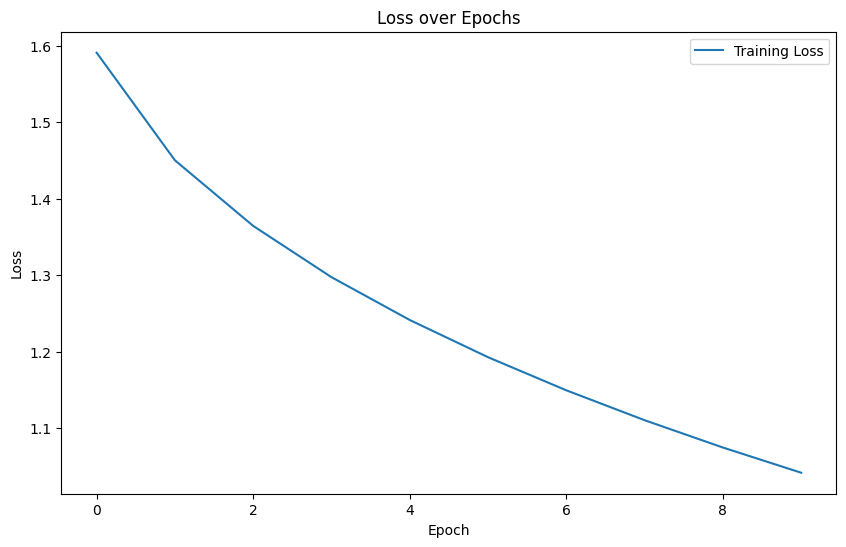

In [ ]:
model = get_model(model_name='state-spaces/mamba-130m')
num_epochs = 10
learning_rate = 1e-4

train_mamba_model(model, tokenizer, test_sentence, num_epochs=num_epochs, learning_rate=learning_rate)

In [ ]:
prompt = "Mamba is the"

n_tokens = 50

generated_text = generate(
    model=model,
    tokenizer=tokenizer,
    prompt=prompt,
    n_tokens_to_gen=n_tokens,
    sample=True,
    top_k=30,
    temperature=0.7
)

print(f"Saída do modelo:\n{generated_text}")

Saída do modelo:
Mamba is the best and highest-level level player.

But what if you want to compete with any other champion in the world? In this way, the game of Mamba will become more difficult.

Ted Kennedy

Who wouldn't love


In [ ]:
prompt = "I did not"

n_tokens = 50

generated_text = generate(
    model=model,
    tokenizer=tokenizer,
    prompt=prompt,
    n_tokens_to_gen=n_tokens,
    sample=True,
    top_k=30,
    temperature=0.7
)

print(f"Saída do modelo:\n{generated_text}")

Saída do modelo:
I did not think he was going to get hurt. I just thought that he was going to struggle a little bit more.

"He's doing well. We all know that. And now we know that he will struggle a little bit more. And he


Após isso, parece que o modelo está realizando uma fala, um discurso, o que é esperado dado o dataset

Bem, temos um modelo em que a loss abaixa (o arquivo txt usado foi o mesmo da atividade 1, o obama-data.txt)